In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.set_style('whitegrid')

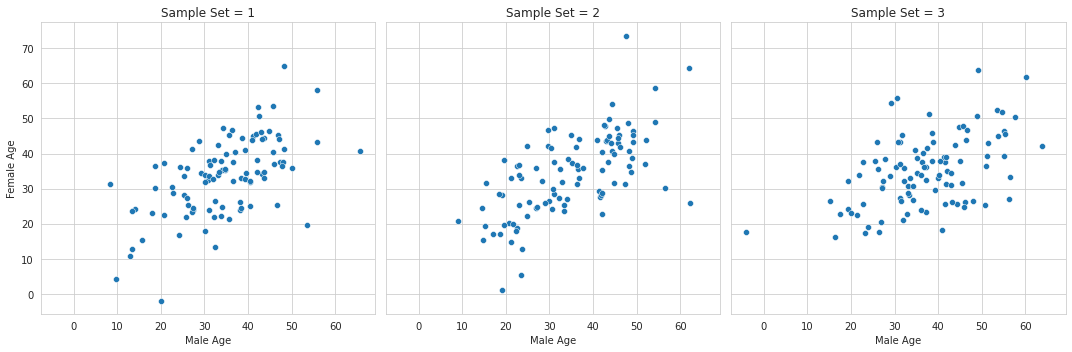

In [109]:
def getMVNPriorSamples(rvTheta, rvS, nEpochs):
    samples = []
    for i in range(nEpochs):
        S = rvS.rvs()
        θ = rvTheta.rvs()
        y = stats.multivariate_normal(θ, S).rvs()
        samples.append(y)
    
    return samples
    
np.random.seed(53423)

SigmaPrior = stats.invwishart(3, np.array([[5, 0], [0, 5]]))
thetaPrior = stats.multivariate_normal(np.array([35,33]), np.array([[1, 0.6], [0.6, 1]])*100)

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for i in range(3):
    sns.scatterplot(data=pd.DataFrame(getMVNPriorSamples(thetaPrior, SigmaPrior, 100)), x=0, y=1, ax=ax[i])
    ax[i].set_xlabel("Male Age")
    ax[i].set_ylabel("Female Age")
    ax[i].set_title(f"Sample Set = {i+1}")

fig.tight_layout()
fig.show()

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from numpy.linalg import inv

class MVNMean:
    def __init__(self, μ0, Σ0):
        self.μ0 = μ0
        self.Σ0 = Σ0
        self.Λ0 = inv(self.Σ0)
    
    def sample_prior(self, n=1):
        return np.random.multivariate_normal(self.μ0, self.Σ0, size=n)
    
    def sample_posterior(self, X, Σ, n=1):
        N = X.shape[0]
        X̄ = X.mean(axis=0)
        Λ = inv(Σ)
        Λn = self.Λ0 + N*Λ
        μn = inv(Λn) @ (Λ @ (N*X̄) + self.Λ0 @ self.μ0)

        return np.random.multivariate_normal(μn, inv(Λn), size=n)

class MVNCov:
    def __init__(self, ν0, S0):
        self.ν0 = ν0
        self.S0 = S0
    
    def sample_prior(self, n=1):
        return stats.invwishart(self.ν0, self.S0).rvs(size=n)
    
    def sample_posterior(self, X, θ, n=1):
        N = X.shape[0]
        νn = self.ν0 + N
        Sθ = (X - θ).T @ (X - θ)
        Sn = self.S0 + Sθ

        return stats.invwishart(νn, Sn).rvs(size=n)

def run_gibbs_sampler(X, θ_rv, Σ_rv, n_epochs, burnin=500):
    N = X.shape[0]

    samples = []
    Σ = np.eye(X.shape[1]) # default init works for improper priors
    for epoch in range(n_epochs+burnin):
        θ = θ_rv.sample_posterior(X, Σ).ravel()
        Σ = Σ_rv.sample_posterior(X, θ)

        ys = stats.multivariate_normal(θ, Σ).rvs(size=N)
        post_corr = np.corrcoef(ys.T)[0,1]

        if epoch < burnin:
            continue
        else:
            samples.append((θ, Σ, post_corr))
    
    return samples

#### (c) My priors

In [14]:
n_epochs = 10000
burin = 500

df = pd.read_csv("agehw.dat", delimiter=" ")
X = df.values

# prior parameters
θ_rv = MVNMean(
    μ0 = np.array([35,33]),
    Σ0 = np.array([
        [100, 60],
        [60, 100]
    ])
)
Σ_rv = MVNCov(
    ν0 = 3,
    S0 = np.array([
        [5, 0],
        [0, 5]
    ])
)

samples = run_gibbs_sampler(X, θ_rv, Σ_rv, n_epochs, burin)

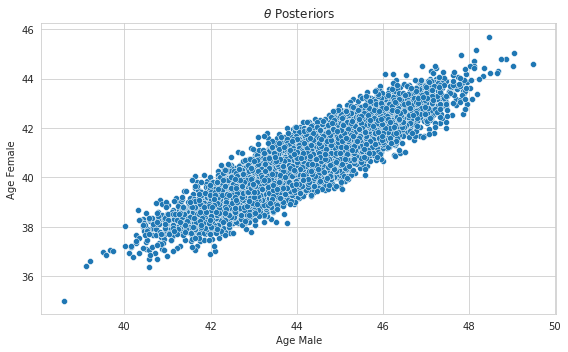

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=pd.DataFrame(list(map(lambda x: x[0], samples))), x=0, y=1, ax=ax)
ax.set_xlabel("Age Male")
ax.set_ylabel("Age Female")
ax.set_title("$\\theta$ Posteriors")

fig.tight_layout()
fig.show()

<AxesSubplot:xlabel='0', ylabel='Density'>

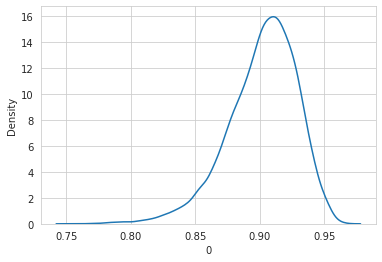

In [53]:
sns.kdeplot(data=pd.DataFrame(list(map(lambda x: x[2], samples))), x=0)

In [29]:
print(pd.DataFrame(list(map(lambda x: x[0], samples))).corr().iloc[0,1])
print(pd.DataFrame(list(map(lambda x: x[0], samples))).quantile([0.25, 0.975]))

0.9029345602187726
               0          1
0.250  43.326934  39.874396
0.975  46.849834  43.228114


#### (d.1) Jerffery Priors

In [6]:
n_epochs = 10000
burin = 500

df = pd.read_csv("agehw.dat", delimiter=" ")
X = df.values

# prior parameters
θ_rv = MVNMean(
    μ0 = np.array([0,0]),
    Σ0 = np.eye(2)
)
Σ_rv = MVNCov(
    ν0 = 1,
    S0 = np.array([
        [0, 0],
        [0, 0]
    ])
)

samples = run_gibbs_sampler(X, θ_rv, Σ_rv, n_epochs, burin)

In [7]:
print(pd.DataFrame(list(map(lambda x: x[0], samples))).corr().iloc[0,1])
print(pd.DataFrame(list(map(lambda x: x[0], samples))).quantile([0.25, 0.975]))

0.20520612104894712
              0         1
0.250  0.612352  0.343244
0.975  3.085259  2.765034


#### (d.2) Unit Information Priors

In [39]:
n_epochs = 10000
burin = 500

df = pd.read_csv("agehw.dat", delimiter=" ")
X = df.values

# prior parameters
θ_rv = MVNMean(
    μ0 = X.mean(0),
    Σ0 = np.cov(X.T)
)
Σ_rv = MVNCov(
    ν0 = 0,
    S0 = np.cov(X.T)
)

samples = run_gibbs_sampler(X, θ_rv, Σ_rv, n_epochs, burin)

In [40]:
print(pd.DataFrame(list(map(lambda x: x[0], samples))).corr().iloc[0,1])
print(pd.DataFrame(list(map(lambda x: x[0], samples))).quantile([0.25, 0.975]))

0.9074009446570009
               0          1
0.250  43.459504  39.984000
0.975  47.105007  43.446811


#### (d.3) Diffuse Prior

In [47]:
n_epochs = 10000
burin = 500

df = pd.read_csv("agehw.dat", delimiter=" ")
X = df.values

# prior parameters
θ_rv = MVNMean(
    μ0 = np.zeros(2),
    Σ0 = np.eye(2) * 10**5
)
Σ_rv = MVNCov(
    ν0 = 3,
    S0 = np.eye(2) * 10**3
)

samples = run_gibbs_sampler(X, θ_rv, Σ_rv, n_epochs, burin)

In [48]:
print(pd.DataFrame(list(map(lambda x: x[0], samples))).corr().iloc[0,1])
print(pd.DataFrame(list(map(lambda x: x[0], samples))).quantile([0.25, 0.975]))

0.8528229215935134
               0          1
0.250  43.470498  39.996675
0.975  47.170396  43.482638
